In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import os

In [3]:
# 파일 경로 설정
file_path = 'WISDM_ar_v1.1_raw.txt'

# --- 1. 파일 불러오기 및 데이터 전처리 ---
print("데이터 전처리 시작...")
try:
    parsed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip().replace(';', '')
            if not line:
                continue
            parts = line.split(',')
            
            if len(parts) > 6:
                activity = parts[1] + ',' + parts[2]
                rest = parts[3:]
                parts = [parts[0], activity] + rest

            if len(parts) == 6:
                parsed_data.append(parts)

    df = pd.DataFrame(parsed_data, columns=['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel'])

    df['user'] = pd.to_numeric(df['user'], errors='coerce')
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['x-accel'] = pd.to_numeric(df['x-accel'], errors='coerce')
    df['y-accel'] = pd.to_numeric(df['y-accel'], errors='coerce')
    df['z-accel'] = pd.to_numeric(df['z-accel'], errors='coerce')
    df['activity'] = df['activity'].str.strip()
    df.dropna(inplace=True)

    print("데이터 전처리 완료. 데이터 정보:")
    df.info()

except FileNotFoundError:
    print(f"오류: {file_path} 파일을 찾을 수 없습니다.")
    exit()

# --- 2. 특징과 라벨 ---
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
FEATURES = ['x-accel', 'y-accel', 'z-accel']
LABELS = ['activity_encoded']

# --- 3. 슬라이딩 윈도우 및 CNN-LSTM 데이터 준비 ---
def prepare_data_for_cnn_lstm(data, window_size, step_size, n_steps, n_length):
    X_list, y_list = [], []
    num_data_points = data.shape[0]

    for i in range(0, num_data_points - window_size, step_size):
        window = data.iloc[i : i + window_size]
        features = window[FEATURES].values
        labels = window[LABELS].values
        most_common_label = Counter(labels.flatten()).most_common(1)[0][0]

        # 데이터를 CNN-LSTM에 맞게 reshape
        # (window_size, num_features) -> (n_steps, n_length, num_features)
        X_list.append(features.reshape((n_steps, n_length, len(FEATURES))))
        y_list.append(most_common_label)
        
    return np.array(X_list), np.array(y_list)

# 윈도우 크기 및 CNN-LSTM을 위한 스텝/길이 설정
WINDOW_SIZE = 50
STEP_SIZE = 25
N_STEPS = 5     # 시퀀스를 나눌 스텝 수 (LSTM 입력)
N_LENGTH = 10   # 각 스텝의 길이 (CNN 입력)

# 데이터 준비
X, y = prepare_data_for_cnn_lstm(df, WINDOW_SIZE, STEP_SIZE, N_STEPS, N_LENGTH)
print("\nCNN-LSTM을 위한 데이터 준비 완료. 특징(X) 및 라벨(y) 형태:")
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

데이터 전처리 시작...
데이터 전처리 완료. 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 1086465 entries, 0 to 1098198
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086465 non-null  int64  
 1   activity   1086465 non-null  object 
 2   timestamp  1086465 non-null  float64
 3   x-accel    1086465 non-null  float64
 4   y-accel    1086465 non-null  float64
 5   z-accel    1086465 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 58.0+ MB

CNN-LSTM을 위한 데이터 준비 완료. 특징(X) 및 라벨(y) 형태:
X.shape: (43457, 5, 10, 3)
y.shape: (43457,)


In [5]:
# --- 4. 학습/테스트 데이터 분리 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\n학습/테스트 데이터 분리 완료.")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


학습/테스트 데이터 분리 완료.
X_train.shape: (34765, 5, 10, 3), y_train.shape: (34765,)
X_test.shape: (8692, 5, 10, 3), y_test.shape: (8692,)


In [7]:

# --- 5. 모델 구성 (CNN-LSTM) ---
def build_cnn_lstm_model(input_shape, num_classes):
    model = keras.Sequential([
        # TimeDistributed를 사용하여 각 시퀀스에 Conv1D를 적용
        keras.layers.TimeDistributed(
            keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
            input_shape=input_shape
        ),
        keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        
        # LSTM 레이어를 추가하여 시퀀스 데이터의 시간적 패턴 학습
        keras.layers.LSTM(units=100, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(units=100),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(units=100, activation='relu'),
        keras.layers.Dense(units=num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

num_classes = len(label_encoder.classes_)
lstm_model = build_cnn_lstm_model(input_shape=(N_STEPS, N_LENGTH, len(FEATURES)),
                                   num_classes=num_classes)
print("\n모델 요약:")
lstm_model.summary()



모델 요약:


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 5, 8, 64)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 5, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 5, 100)              │         142,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 234,546 (916.20 KB)

 Trainable params: 234,546 (916.20 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# --- 6. 모델 학습 ---
EPOCHS = 20
BATCH_SIZE = 64
history = lstm_model.fit(X_train, y_train,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(X_test, y_test),
                         verbose=1)


Epoch 1/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7513 - loss: 0.7036 - val_accuracy: 0.8881 - val_loss: 0.3068
Epoch 2/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8987 - loss: 0.2804 - val_accuracy: 0.9152 - val_loss: 0.2340
Epoch 3/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9295 - loss: 0.1948 - val_accuracy: 0.9325 - val_loss: 0.2003
Epoch 4/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9497 - loss: 0.1459 - val_accuracy: 0.9451 - val_loss: 0.1629
Epoch 5/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9578 - loss: 0.1256 - val_accuracy: 0.9534 - val_loss: 0.1404
Epoch 6/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9674 - loss: 0.1006 - val_accuracy: 0.9582 - val_loss: 0.1220
Epoch 7/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9735 - loss: 0.0821 - val_accuracy: 0.9590 - val_loss: 0.1392
Epoch 8/20
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9755 - loss: 0.0728 - val_acc


--- 모델 평가 결과 ---
테스트 손실 (Test Loss): 0.1271
테스트 정확도 (Test Accuracy): 0.9679


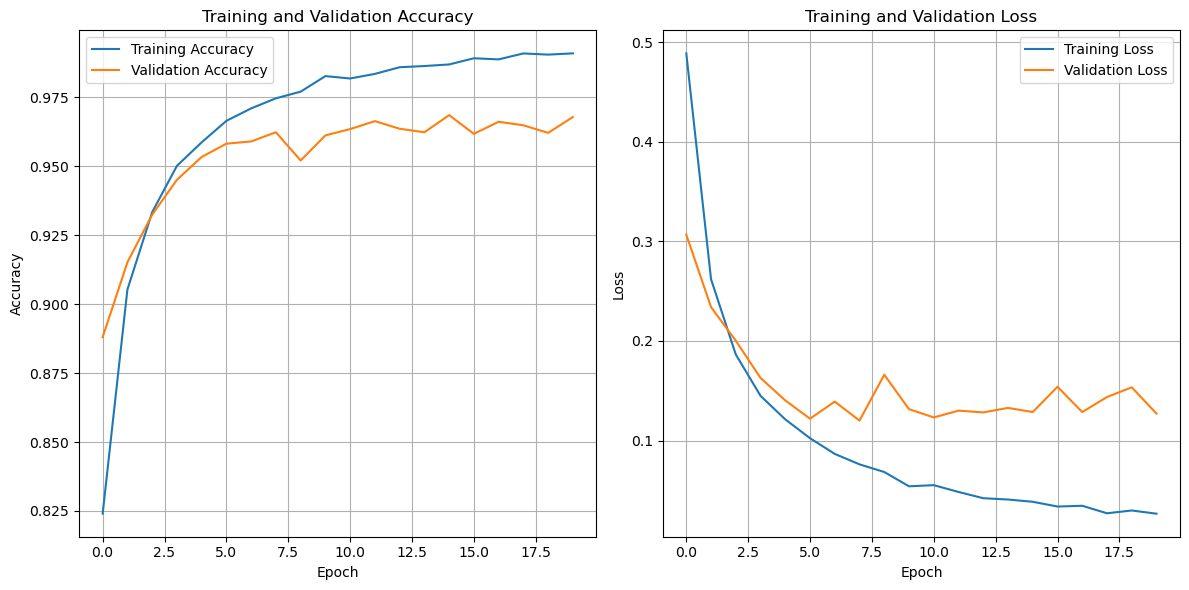

In [11]:
# --- 7. 평가 및 시각화 ---
print("\n--- 모델 평가 결과 ---")
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 손실 (Test Loss): {loss:.4f}")
print(f"테스트 정확도 (Test Accuracy): {accuracy:.4f}")

# 정확도 및 손실 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()